In [ ]:
import os
import pandas as pd
import tensorflow as tf

# Function to compute basic statistics for an image
def compute_basic_image_statistics(filename):
    """
    Computes basic statistics of an image.

    Args:
        filename (str): The path to the image file.

    Returns:
        dict: A dictionary containing the following statistics:
            - "filename": The path to the image file.
            - "resolution": The resolution of the image as a tuple (width, height).
            - "aspect_ratio": The aspect ratio of the image.
            - "file_size": The size of the image file in bytes.
    """
    # Load the image
    image_string = tf.io.read_file(filename)
    image = tf.io.decode_image(image_string, channels=3)
    
    # Compute basic statistics
    image_shape = tf.shape(image)
    width, height = image_shape[1], image_shape[0]
    resolution = (width.numpy(), height.numpy())
    aspect_ratio = width.numpy() / height.numpy() if height.numpy() != 0 else 0
    file_size = os.path.getsize(filename)

    return {
        "filename": filename,
        "resolution": resolution,
        "aspect_ratio": aspect_ratio,
        "file_size": file_size
    }

# Load CSV file
test_csv = '../images/Test.csv'
test_df = pd.read_csv(test_csv)

# Directory where the images are stored
image_directory = '../images/images/'

# Compute basic statistics for each image
basic_stats = []
for _, row in test_df.iterrows():
    filename = os.path.join(image_directory, row['filename'])
    image_stats = compute_basic_image_statistics(filename)
    basic_stats.append(image_stats)

# Create a DataFrame from the basic statistics
basic_stats_df = pd.DataFrame(basic_stats)

# Prepare the summary
total_images = len(basic_stats_df)
resolution_counts = basic_stats_df['resolution'].value_counts()
average_file_size = basic_stats_df['file_size'].mean()
min_file_size = basic_stats_df['file_size'].min()
max_file_size = basic_stats_df['file_size'].max()
median_file_size = basic_stats_df['file_size'].median()
aspect_ratio_counts = basic_stats_df['aspect_ratio'].value_counts()

# Presenting the summary
print(f"Image Dataset Summary:\n")
print(f"Total Number of Images: {total_images}\n")
print("Distribution of Image Resolutions:")
print(resolution_counts, "\n")
print(f"File Size Statistics:")
print(f"  - Average File Size: {average_file_size:.2f} bytes")
print(f"  - Minimum File Size: {min_file_size} bytes")
print(f"  - Maximum File Size: {max_file_size} bytes")
print(f"  - Median File Size: {median_file_size} bytes\n")
print("Aspect Ratio Distribution:")
print(aspect_ratio_counts, "\n")


In [ ]:
import os
import pandas as pd
import tensorflow as tf

# Function to compute the resolution of an image
def compute_resolution(filename):
    """
    Computes the resolution of an image file.

    Parameters:
    filename (str): The path to the image file.

    Returns:
    str: The resolution of the image in the format "width x height".

    Raises:
    None.
    """
    try:
        image_string = tf.io.read_file(filename)
        image = tf.io.decode_image(image_string, channels=3)
        image_shape = tf.shape(image)
        # Convert resolution to a string for easy comparison
        return f"{image_shape[1].numpy()}x{image_shape[0].numpy()}"
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

# Load the Test and Train datasets
test_csv = '../images/Test.csv'
train_csv = '../images/Train.csv'

test_df = pd.read_csv(test_csv)
train_df = pd.read_csv(train_csv)

# Directories where the images are stored
test_image_directory = '../images/images/'
train_image_directory = '../images/images/'

# Compute resolutions for the test and training sets
test_df['resolution'] = test_df['filename'].apply(lambda x: compute_resolution(os.path.join(test_image_directory, x)))
train_df['resolution'] = train_df['filename'].apply(lambda x: compute_resolution(os.path.join(train_image_directory, x)))

# Analyze the resolution distribution in the test set
test_resolution_distribution = test_df['resolution'].value_counts(normalize=True)

# Initialize a list to hold the representative training images
representative_train_images = []

# Sampling strategy
for resolution, proportion in test_resolution_distribution.items():
    resolution_subset = train_df[train_df['resolution'] == resolution]

    if not resolution_subset.empty:
        # Calculate the number of images to sample for this resolution
        num_samples = int(proportion * len(train_df))

        # Sample images
        samples = resolution_subset.sample(n=num_samples, replace=True)

        # Append to the list
        representative_train_images.append(samples)

# Concatenate all sampled DataFrames
representative_train_images_df = pd.concat(representative_train_images, ignore_index=True)

# Save the representative_train_images DataFrame to disk
representative_train_images_df.to_csv('../images/representative_train_images.csv', index=False)

print("Representative training images saved to 'representative_train_images.csv'")

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Resizing, Rescaling, Permute
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from transformers import TFViTModel

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Additional configurations for reproducibility
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Configuration constants
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1.5e-5,
    "N_EPOCHS": 20,
    "NUM_CLASSES": 5,
    "VALIDATION_SPLIT": 0.2,
    "OUTPUT_ATTENTIONS": True,
    "CLASS_NAMES": ["DR", "G", "ND", "WD", "other"],
}

# Loss function and metrics
loss_function = CategoricalCrossentropy()
metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=2, name="top_k_accuracy")
]

# Directory where the images are stored
train_directory = '../images/images/'

# CSV file path
csv_file = '../images/train_images.csv'

# Load the CSV file as a dataset
csv_dataset = tf.data.experimental.CsvDataset(
    csv_file, [tf.string, tf.string, tf.string], header=True)

# Create a lookup table for class names to indices
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(CONFIGURATION["CLASS_NAMES"]),
        values=tf.constant(list(range(len(CONFIGURATION["CLASS_NAMES"])))),
    ),
    default_value=-1
)

def process_row(id, label, filename):
    """
    Function to process each row of the CSV file.
    It loads the image, decodes, resizes, and one-hot encodes the label.

    Parameters:
    - id: The ID of the row.
    - label: The label of the image.
    - filename: The filename of the image.

    Returns:
    - image_resized: The resized image.
    - label_encoded: The one-hot encoded label.
    """
    image_string = tf.io.read_file(train_directory + '/' + filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, [CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]])
    label_index = table.lookup(label)
    label_encoded = tf.one_hot(label_index, depth=len(CONFIGURATION["CLASS_NAMES"]))

    return image_resized, label_encoded

# Apply the function to each row and prepare the dataset
dataset = csv_dataset.map(process_row)

# Determine the number of total data points and calculate validation size
dataset_size = sum(1 for _ in dataset)
validation_size = int(dataset_size * CONFIGURATION["VALIDATION_SPLIT"])

# Shuffle the dataset
dataset = dataset.shuffle(dataset_size)

# Split the dataset into training and validation sets
validation_dataset = dataset.take(validation_size)
train_dataset = dataset.skip(validation_size)

# Batch the datasets
train_dataset = train_dataset.batch(CONFIGURATION["BATCH_SIZE"])
validation_dataset = validation_dataset.batch(CONFIGURATION["BATCH_SIZE"])

# Preprocessing layers for the model input
resize_rescale = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1./255),
    Permute((3, 1, 2))
])

# Load the pre-trained ViT model with output attentions enabled
base_model = TFViTModel.from_pretrained(
    "google/vit-base-patch16-224",
    output_attentions=CONFIGURATION["OUTPUT_ATTENTIONS"]
)

inputs = Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))
x = resize_rescale(inputs)
x = base_model.vit(x)[0][:, 0, :]
output = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model
hf_model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
                 loss=loss_function,
                 metrics=metrics)

# Train the model with validation data
history = hf_model.fit(
    train_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    validation_data=validation_dataset,
    verbose=1
)


c:\Users\moses\intelpython3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3

5/5 [==============================] - 227s 42s/step - loss: 1.5133 - accuracy: 0.3938 - top_k_accuracy: 0.6687 - val_loss: 0.9255 - val_accuracy: 0.6250 - val_top_k_accuracy: 0.8750
Epoch 2/3
5/5 [==============================] - 303s 54s/step - loss: 0.8669 - accuracy: 0.6438 - top_k_accuracy: 0.8625 - val_loss: 0.4740 - val_accuracy: 0.8250 - val_top_k_accuracy: 0.9500
Epoch 3/3
5/5 [==============================] - 208s 42s/step - loss: 0.5493 - accuracy: 0.8062 - top_k_accuracy: 0.9563 - val_loss: 0.6022 - val_accuracy: 0.7000 - val_top_k_accuracy: 0.9750


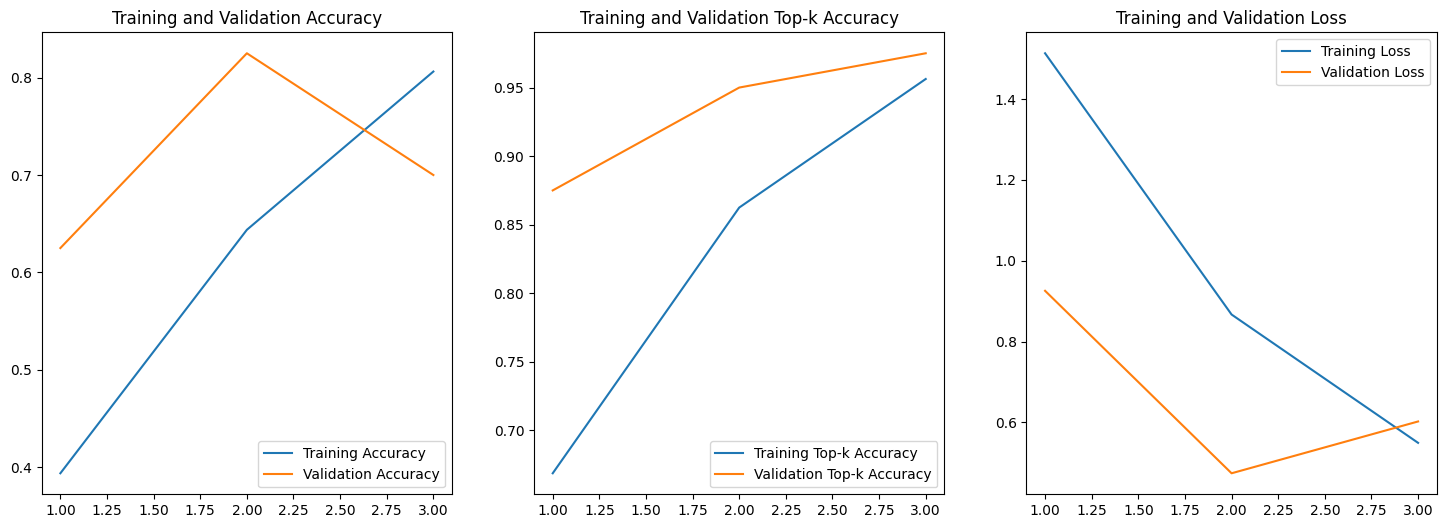

In [2]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation metrics over epochs.

    Parameters:
    - history: A history object containing the training metrics.

    Returns:
    None
    """
    # Extracting the metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    top_k_acc = history.history['top_k_accuracy']
    val_top_k_acc = history.history['val_top_k_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, CONFIGURATION["N_EPOCHS"] + 1)
    
    plt.figure(figsize=(18, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation top-k accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, top_k_acc, label='Training Top-k Accuracy')
    plt.plot(epochs_range, val_top_k_acc, label='Validation Top-k Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Top-k Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot the metrics
plot_training_history(history)


In [3]:
import numpy as np

def preprocess_image(image_path):
    """
    Preprocesses an image by loading, decoding, resizing, and rescaling it.

    Args:
        image_path (str): The path to the image file.

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    # Load and decode the image
    image_string = tf.io.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # Resize and rescale the image
    resize_rescale = tf.keras.Sequential([
        Resizing(256, 256),  # Resizing to 256x256 as per model's expected input
        Rescaling(1./255)
    ])
    image_processed = resize_rescale(tf.expand_dims(image_decoded, axis=0))

    return image_processed


# Example usage
image_path = '../images/images/testimage.jpg'
processed_image = preprocess_image(image_path)
def make_prediction_with_probabilities(model, processed_image):
    predictions = model.predict(processed_image)
    return predictions


# Make a prediction and get probabilities
predictions = make_prediction_with_probabilities(hf_model, processed_image)

# Get the predicted class and probabilities
predicted_class_idx = np.argmax(predictions, axis=1)[0]
predicted_class_name = CONFIGURATION["CLASS_NAMES"][predicted_class_idx]
predicted_probabilities = predictions[0]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probabilities: {predicted_probabilities}")

# If you want to display the probabilities with class names
for class_name, probability in zip(CONFIGURATION["CLASS_NAMES"], predicted_probabilities):
    print(f"{class_name}: {probability}")


1/1 [==============================] - 4s 4s/step
Predicted Class: DR
Probabilities: [0.37897265 0.29918936 0.02086283 0.27406543 0.02690971]
DR: 0.3789726495742798
G: 0.29918935894966125
ND: 0.02086283080279827
WD: 0.27406543493270874
other: 0.026909712702035904


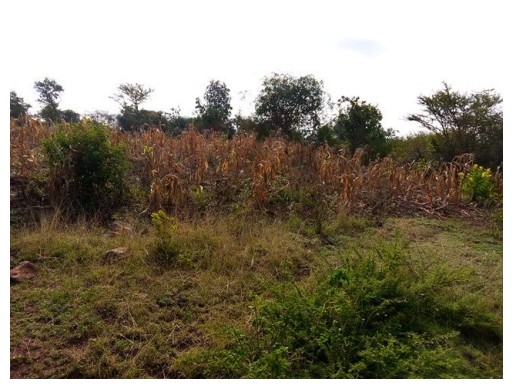

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    """
    Display the image located at the given image_path.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    None
    """
    # Load the image
    img = mpimg.imread(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Example usage
show_image(image_path)
